## Analysis of Robinhood Portfolio (robin_$tocks)

Project by: Pete Aguirre II

In this project, I will do a retuern:risk analysis on my current Robinhood stock portfolio with the help of multiple 
tools using:
- Python 3
- Jupyter Lab/Notebook
- Beautiful Soup
- Markowitz Efficent Frontier

## TO DO LIST:
- Create a daily, weekly, quarterly, yearly portfolio performance
- Learn how to create beatiful graphs
- Create interactive dashboards 
- Learn Monte Carlo Simulations

In [1]:
# Installing libraries 
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install robin_stocks

# Libraries Used 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import robin_stocks as r 
import pyotp

from pandas_datareader import data as wb

# Magic
%matplotlib inline

## 1.) Data Collection (updated)
Notes: Log in with Robinhood and portfolio will be gathered automatically

In [ ]:
# Robinhood Log In 
email = input("Enter email: ")
password = input("Enter password: ")

totp = pyotp.TOTP("My2factorAppHere").now()
log_in = r.login(email, password, expiresIn=500, by_sms=True, mfa_code=totp)

# Get stocks value
stonks = r.build_holdings()

# Logout 
r.logout()

In [3]:
# Company tickers
# Since the company tickers are the keys, and the other variables are values, 
# create a dataframe for symbols first.
symbols_df = []
for k in  stonks.keys():
    symbols_df.append(k)
symbols_df = np.array(symbols_df)
symbols_df = pd.DataFrame(symbols_df, columns=['Symbol'])
symbols_df

,Symbol
0,AAPL
1,BABA
2,SPHD
3,BRK.B
4,TSLA
5,XOM
6,JD
7,LUV
8,DAL


In [4]:
# Other headers 
# Create a dataframe for the other headers (which are values to the symbol keys).
# Drop some variables: percent_change, equity_change, type, and id 
# Rename the variables to something nicer looking
variables_df = pd.DataFrame.from_dict(stonks.values())
variables_df = variables_df.drop(['percent_change', 'equity_change', 'type', 'id', 'percentage'], axis=1)
variables_df = variables_df.rename(columns={'price':'Price', 'quantity':'Quantity', 'average_buy_price':'Average Price', 'equity':'Equity', 'name':'Name', 'pe_ratio':'P/E'})
variables_df

,Average Price,Equity,Name,P/E,Price,Quantity
0,426.6150,4624.95,Apple,33.251800,462.495000,10.00000000
1,246.0856,2545.80,Alibaba,30.461500,254.580100,10.00000000
2,34.8451,2136.35,PowerShares S&P 500 High Dividend Low Volatili...,16.079538,34.665000,61.62858000
3,211.3009,2120.60,Berkshire Hathaway,23.292400,212.060000,10.00000000
4,1629.0200,1637.67,Tesla,715.269000,1637.670800,1.00000000
5,42.4100,866.62,Exxon Mobil,26.779000,43.331000,20.00000000
6,63.0859,630.45,JD.com,105.483000,63.045000,10.00000000
7,31.7173,524.70,Southwest Airlines,87.851600,34.980000,15.00000000
8,25.0280,433.05,Delta Air Lines,None,28.870000,15.00000000


## 2.) Data Cleaning

In [5]:
# Concatinate both DataFrames 
my_portfolio = pd.concat([symbols_df, variables_df], axis=1)
my_portfolio

,Symbol,Average Price,Equity,Name,P/E,Price,Quantity
0,AAPL,426.6150,4624.95,Apple,33.251800,462.495000,10.00000000
1,BABA,246.0856,2545.80,Alibaba,30.461500,254.580100,10.00000000
2,SPHD,34.8451,2136.35,PowerShares S&P 500 High Dividend Low Volatili...,16.079538,34.665000,61.62858000
3,BRK.B,211.3009,2120.60,Berkshire Hathaway,23.292400,212.060000,10.00000000
4,TSLA,1629.0200,1637.67,Tesla,715.269000,1637.670800,1.00000000
5,XOM,42.4100,866.62,Exxon Mobil,26.779000,43.331000,20.00000000
6,JD,63.0859,630.45,JD.com,105.483000,63.045000,10.00000000
7,LUV,31.7173,524.70,Southwest Airlines,87.851600,34.980000,15.00000000
8,DAL,25.0280,433.05,Delta Air Lines,None,28.870000,15.00000000


In [6]:
# Check variable types
my_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
Symbol           9 non-null object
Average Price    9 non-null object
Equity           9 non-null object
Name             9 non-null object
P/E              8 non-null object
Price            9 non-null object
Quantity         9 non-null object
dtypes: object(7)
memory usage: 584.0+ bytes


In [7]:
# Change some values to floats and round them to 2 decimal numbers
my_portfolio['Price'] = my_portfolio['Price'].astype(float)
my_portfolio['Quantity'] = my_portfolio['Quantity'].astype(float).astype(int)
my_portfolio['Average Price'] = round(my_portfolio['Average Price'].astype(float), 2)
my_portfolio['Equity'] = round(my_portfolio['Equity'].astype(float), 2)
my_portfolio['P/E'] = my_portfolio['P/E'].astype(float)
my_portfolio

,Symbol,Average Price,Equity,Name,P/E,Price,Quantity
0,AAPL,426.62,4624.95,Apple,33.251800,462.4950,10
1,BABA,246.09,2545.80,Alibaba,30.461500,254.5801,10
2,SPHD,34.85,2136.35,PowerShares S&P 500 High Dividend Low Volatili...,16.079538,34.6650,61
3,BRK.B,211.30,2120.60,Berkshire Hathaway,23.292400,212.0600,10
4,TSLA,1629.02,1637.67,Tesla,715.269000,1637.6708,1
5,XOM,42.41,866.62,Exxon Mobil,26.779000,43.3310,20
6,JD,63.09,630.45,JD.com,105.483000,63.0450,10
7,LUV,31.72,524.70,Southwest Airlines,87.851600,34.9800,15
8,DAL,25.03,433.05,Delta Air Lines,NaN,28.8700,15


In [8]:
# Check once more
# Note: at this point, numbers should be floats
my_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
Symbol           9 non-null object
Average Price    9 non-null float64
Equity           9 non-null float64
Name             9 non-null object
P/E              8 non-null float64
Price            9 non-null float64
Quantity         9 non-null int32
dtypes: float64(4), int32(1), object(2)
memory usage: 548.0+ bytes


In [9]:
my_portfolio = my_portfolio[["Name","Symbol","Price","Quantity","Average Price","Equity","P/E"]]
# my_portfolio

In [10]:
# Convert any '.' to '-' in symbols
my_portfolio['Symbol'] = my_portfolio['Symbol'].str.replace(".", "-")

In [11]:
# Confirm that '.' has been replaced by '-' on symbol
my_portfolio

,Name,Symbol,Price,Quantity,Average Price,Equity,P/E
0,Apple,AAPL,462.4950,10,426.62,4624.95,33.251800
1,Alibaba,BABA,254.5801,10,246.09,2545.80,30.461500
2,PowerShares S&P 500 High Dividend Low Volatili...,SPHD,34.6650,61,34.85,2136.35,16.079538
3,Berkshire Hathaway,BRK-B,212.0600,10,211.30,2120.60,23.292400
4,Tesla,TSLA,1637.6708,1,1629.02,1637.67,715.269000
5,Exxon Mobil,XOM,43.3310,20,42.41,866.62,26.779000
6,JD.com,JD,63.0450,10,63.09,630.45,105.483000
7,Southwest Airlines,LUV,34.9800,15,31.72,524.70,87.851600
8,Delta Air Lines,DAL,28.8700,15,25.03,433.05,NaN


In [12]:
# Create weights for each company
# capital = sigma(quantity * average price)
# weights = (quantity * average price)/capital

capital = np.sum(my_portfolio['Quantity']*my_portfolio['Average Price'])
weights = []

for w in range(len(my_portfolio)):
    weights.append(round(((my_portfolio['Quantity'][w] * my_portfolio['Average Price'][w])/capital), 2))

weights_df = np.array(weights)
weights_df = pd.DataFrame({'Weights':weights})



In [13]:
# Ensure that these are the only variables included
my_portfolio = pd.concat([my_portfolio, weights_df], axis=1)
my_portfolio

,Name,Symbol,Price,Quantity,Average Price,Equity,P/E,Weights
0,Apple,AAPL,462.4950,10,426.62,4624.95,33.251800,0.29
1,Alibaba,BABA,254.5801,10,246.09,2545.80,30.461500,0.16
2,PowerShares S&P 500 High Dividend Low Volatili...,SPHD,34.6650,61,34.85,2136.35,16.079538,0.14
3,Berkshire Hathaway,BRK-B,212.0600,10,211.30,2120.60,23.292400,0.14
4,Tesla,TSLA,1637.6708,1,1629.02,1637.67,715.269000,0.11
5,Exxon Mobil,XOM,43.3310,20,42.41,866.62,26.779000,0.06
6,JD.com,JD,63.0450,10,63.09,630.45,105.483000,0.04
7,Southwest Airlines,LUV,34.9800,15,31.72,524.70,87.851600,0.03
8,Delta Air Lines,DAL,28.8700,15,25.03,433.05,NaN,0.03


## 3.) Data Collection of Historical Prices

In [14]:
# Collect historical prices by Yahoo! Finance est. 2000 
tickers = my_portfolio['Symbol']
start_date = '2000-01-01'
historical_data = pd.DataFrame()
for t in tickers:
    historical_data[t] = wb.DataReader(t, data_source='yahoo', start=start_date)['Adj Close']

In [15]:
# Remove all rows that includes NaN values
# Check if all columns match and are float variables
historical_data = historical_data.dropna()
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1486 entries, 2014-09-19 to 2020-08-13
Data columns (total 9 columns):
AAPL     1486 non-null float64
BABA     1486 non-null float64
SPHD     1486 non-null float64
BRK-B    1486 non-null float64
TSLA     1486 non-null float64
XOM      1486 non-null float64
JD       1486 non-null float64
LUV      1486 non-null float64
DAL      1486 non-null float64
dtypes: float64(9)
memory usage: 116.1 KB


In [16]:
historical_data.head()

,AAPL,BABA,SPHD,BRK-B,TSLA,XOM,JD,LUV,DAL
Date,,,,,,,,,
2014-09-19,91.730469,93.889999,24.605312,140.559998,259.320007,75.382065,28.350000,32.756878,34.706215
2014-09-22,91.821304,89.889999,24.534039,139.259995,250.029999,74.931900,26.969999,32.368275,34.086460
2014-09-23,93.256874,87.169998,24.383572,138.779999,250.410004,74.536041,26.570000,31.524702,33.861919
2014-09-24,92.448242,90.570000,24.486519,139.949997,252.139999,74.373047,27.180000,32.538883,33.825985
2014-09-25,88.922958,88.919998,24.296457,137.089996,246.949997,73.154457,26.570000,31.884882,32.927792


In [17]:
historical_data.tail()

,AAPL,BABA,SPHD,BRK-B,TSLA,XOM,JD,LUV,DAL
Date,,,,,,,,,
2020-08-07,444.450012,252.100006,34.419998,209.479996,1452.709961,42.599598,62.060001,33.279999,27.180000
2020-08-10,450.910004,248.130005,35.049999,212.580002,1418.569946,43.648899,61.490002,34.990002,29.340000
2020-08-11,437.500000,248.419998,34.980000,212.660004,1374.390015,44.100002,61.180000,35.290001,29.639999
2020-08-12,452.040009,255.190002,35.040001,213.240005,1554.760010,44.090000,62.900002,35.250000,29.090000
2020-08-13,462.446411,254.580093,34.665001,212.059998,1638.000000,43.331001,63.040001,34.974998,28.870001


In [18]:
# Calculate log returns of each companies 
# Check if all columns match and are float variables
returns = np.log(historical_data/historical_data.shift(1))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1486 entries, 2014-09-19 to 2020-08-13
Data columns (total 9 columns):
AAPL     1485 non-null float64
BABA     1485 non-null float64
SPHD     1485 non-null float64
BRK-B    1485 non-null float64
TSLA     1485 non-null float64
XOM      1485 non-null float64
JD       1485 non-null float64
LUV      1485 non-null float64
DAL      1485 non-null float64
dtypes: float64(9)
memory usage: 116.1 KB


In [19]:
returns.head()

,AAPL,BABA,SPHD,BRK-B,TSLA,XOM,JD,LUV,DAL
Date,,,,,,,,,
2014-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-22,0.000990,-0.043537,-0.002901,-0.009292,-0.036482,-0.005990,-0.049902,-0.011934,-0.018019
2014-09-23,0.015513,-0.030726,-0.006152,-0.003453,0.001519,-0.005297,-0.014942,-0.026407,-0.006609
2014-09-24,-0.008709,0.038263,0.004213,0.008395,0.006885,-0.002189,0.022699,0.031664,-0.001062
2014-09-25,-0.038879,-0.018386,-0.007792,-0.020648,-0.020799,-0.016521,-0.022699,-0.020304,-0.026912


In [20]:
returns.tail()

,AAPL,BABA,SPHD,BRK-B,TSLA,XOM,JD,LUV,DAL
Date,,,,,,,,,
2020-08-07,-0.022998,-0.052467,0.011983,0.021521,-0.025063,-0.004594,-0.044900,0.007843,0.003686
2020-08-10,0.014430,-0.015873,0.018138,0.014690,-0.023781,0.024333,-0.009227,0.050106,0.076470
2020-08-11,-0.030191,0.001168,-0.001999,0.000376,-0.031639,0.010282,-0.005054,0.008537,0.010173
2020-08-12,0.032694,0.026888,0.001714,0.002724,0.123311,-0.000227,0.027726,-0.001134,-0.018730
2020-08-13,0.022760,-0.002393,-0.010760,-0.005549,0.052155,-0.017365,0.002223,-0.007832,-0.007591


## 4.) Data Analysis

In [21]:
# Create a table for Daily and Annual Risk Returns 
# Daily mean formula: daily_mean = returns.mean()
# Daily stdv formula: daily_mean = returns.std()
# Annual mean formula: annual_mean = returns.mean()*250
# Annual stdv formula: annual_mean = returns.std()*250 ** .5

daily_mean = []
daily_stdv = []

annual_mean = []
annual_stdv = []

for t in tickers:
    daily_mean.append(round(returns[t].mean()*100, 2))
    daily_stdv.append(round(returns[t].std()*100, 2))
    
    annual_mean.append(round((returns[t].mean()*250)*100, 2))
    annual_stdv.append(round((returns[t].std()*250**.5)*100, 2))

daily_mean = np.array(daily_mean)
daily_stdv = np.array(daily_stdv)
annual_mean = np.array(annual_mean)
annual_stdv = np.array(annual_stdv)
annual_stdv

array([28.48, 32.61, 19.  , 20.59, 52.3 , 26.1 , 41.29, 35.64, 40.79])

In [22]:
# Create DataFrame for returns and risk 
returns_data = pd.DataFrame({'Symbol':tickers, 
                             'Daily Average Return (%)':daily_mean,
                             'Daily Risk (%)':daily_stdv,
                             'Annual Average Return (%)':annual_mean,
                             'Annual Risk (%)':annual_stdv
                            })
returns_data

,Symbol,Daily Average Return (%),Daily Risk (%),Annual Average Return (%),Annual Risk (%)
0,AAPL,0.11,1.80,27.23,28.48
1,BABA,0.07,2.06,16.79,32.61
2,SPHD,0.02,1.20,5.77,19.00
3,BRK-B,0.03,1.30,6.92,20.59
4,TSLA,0.12,3.31,31.03,52.30
5,XOM,-0.04,1.65,-9.32,26.10
6,JD,0.05,2.61,13.45,41.29
7,LUV,0.00,2.25,1.10,35.64
8,DAL,-0.01,2.58,-3.10,40.79


In [23]:
# Returns the lowest return in history between 09-30-2014 to now
returns.idxmin() 

AAPL    2020-03-16
BABA    2015-01-29
SPHD    2020-03-16
BRK-B   2020-03-12
TSLA    2020-03-16
XOM     2020-03-09
JD      2020-03-16
LUV     2020-03-12
DAL     2020-03-18
dtype: datetime64[ns]

In [24]:
# Returns the highest return in history between 09-30-2014 to now
returns.idxmax()

AAPL    2020-03-13
BABA    2017-06-08
SPHD    2020-03-24
BRK-B   2020-03-13
TSLA    2020-02-03
XOM     2020-03-24
JD      2019-08-13
LUV     2020-03-13
DAL     2020-03-24
dtype: datetime64[ns]

In [25]:
# Covariance daily
# Determines if there is a relationship between two stocks, whether they move together:
# positively, negatively, or neutral 
return_cov = returns.cov()
return_cov

,AAPL,BABA,SPHD,BRK-B,TSLA,XOM,JD,LUV,DAL
AAPL,0.000324,0.000173,0.000121,0.000137,0.000223,0.000137,0.000212,0.000152,0.000179
BABA,0.000173,0.000425,0.000087,0.000102,0.000223,0.000105,0.000338,0.000135,0.000162
SPHD,0.000121,0.000087,0.000144,0.000125,0.000137,0.000147,0.000105,0.000153,0.000187
BRK-B,0.000137,0.000102,0.000125,0.000170,0.000136,0.000145,0.000123,0.000157,0.000190
TSLA,0.000223,0.000223,0.000137,0.000136,0.001094,0.000158,0.000292,0.000165,0.000236
XOM,0.000137,0.000105,0.000147,0.000145,0.000158,0.000273,0.000129,0.000149,0.000188
JD,0.000212,0.000338,0.000105,0.000123,0.000292,0.000129,0.000682,0.000163,0.000172
LUV,0.000152,0.000135,0.000153,0.000157,0.000165,0.000149,0.000163,0.000508,0.000449
DAL,0.000179,0.000162,0.000187,0.000190,0.000236,0.000188,0.000172,0.000449,0.000665


In [26]:
# Covariance yearly
# Determines if there is a relationship between two stocks, whether they move together:
# positively, negatively, or neutral 
return_cov = returns.cov()*250
return_cov

,AAPL,BABA,SPHD,BRK-B,TSLA,XOM,JD,LUV,DAL
AAPL,0.081097,0.043315,0.030260,0.034170,0.055732,0.034160,0.053099,0.038105,0.044657
BABA,0.043315,0.106312,0.021685,0.025562,0.055664,0.026350,0.084392,0.033736,0.040534
SPHD,0.030260,0.021685,0.036104,0.031162,0.034303,0.036754,0.026227,0.038356,0.046702
BRK-B,0.034170,0.025562,0.031162,0.042388,0.034045,0.036141,0.030674,0.039192,0.047446
TSLA,0.055732,0.055664,0.034303,0.034045,0.273518,0.039609,0.072917,0.041292,0.058972
XOM,0.034160,0.026350,0.036754,0.036141,0.039609,0.068146,0.032159,0.037131,0.046899
JD,0.053099,0.084392,0.026227,0.030674,0.072917,0.032159,0.170515,0.040667,0.042897
LUV,0.038105,0.033736,0.038356,0.039192,0.041292,0.037131,0.040667,0.126986,0.112231
DAL,0.044657,0.040534,0.046702,0.047446,0.058972,0.046899,0.042897,0.112231,0.166353


In [27]:
# Correlations
# Determines how close the relationship are between two stocks
return_corr = returns.corr()
return_corr

,AAPL,BABA,SPHD,BRK-B,TSLA,XOM,JD,LUV,DAL
AAPL,1.000000,0.466493,0.559229,0.582801,0.374203,0.459511,0.451550,0.375489,0.384481
BABA,0.466493,1.000000,0.350011,0.380784,0.326431,0.309577,0.626798,0.290351,0.304799
SPHD,0.559229,0.350011,1.000000,0.796582,0.345191,0.740980,0.334269,0.566475,0.602613
BRK-B,0.582801,0.380784,0.796582,1.000000,0.316182,0.672459,0.360805,0.534201,0.565023
TSLA,0.374203,0.326431,0.345191,0.316182,1.000000,0.290119,0.337641,0.221564,0.276462
XOM,0.459511,0.309577,0.740980,0.672459,0.290119,1.000000,0.298337,0.399148,0.440485
JD,0.451550,0.626798,0.334269,0.360805,0.337641,0.298337,1.000000,0.276365,0.254699
LUV,0.375489,0.290351,0.566475,0.534201,0.221564,0.399148,0.276365,1.000000,0.772181
DAL,0.384481,0.304799,0.602613,0.565023,0.276462,0.440485,0.254699,0.772181,1.000000


In [28]:
# Calculating Diversifiable and Non-Diversifiable

# Portfolio variance
pflio_var = np.dot(my_portfolio['Weights'].T, np.dot(returns.cov()*250, my_portfolio['Weights']))
print("Portfolio Variance", pflio_var)

# Portfolio volatility 
#pflio_vol = (np.dot(my_portfolio['Weight'].T, np.dot(sec_returns.cov()*250, my_portfolio['Weight'])))**.5
#print("Portfolio Volatility:", pflio_vol)

# or...

pflio_vol2 = np.sqrt(pflio_var)
print("Portfolio Volatility:", pflio_vol2)


# Calculating variance annually for each tickers
var_a = []
for t in tickers:
    var_a.append(returns[t].var()*250)

var_a = np.array(var_a)
variances = pd.DataFrame({'Symbol':tickers, 'Variance':var_a})
print("")
# Diversifiable Risk
# div_risk = pflio_var - my_portfolio['Weight'][0]**2*variances['Variance'][0] - ...
#                  ... - my_portfolio['Weight'][n]**2*variances['Variance'][n]
div_risk = 0   
for i in range(len(my_portfolio)):
    if i==0:
        div_risk = pflio_var - my_portfolio['Weights'][0]**2*variances['Variance'][0]
    else:
        div_risk -= my_portfolio['Weights'][i]**2*variances['Variance'][i]
print("Diversifiable Risk:", div_risk)

print("")
# Non Diversifiable Risk
non_div_risk1 = pflio_var - div_risk
non_div_risk1 = round(non_div_risk1, 4)
print("Non-Diversifiable Risk:", non_div_risk1)

print("")
non_div_risk2 = 0
for i in range(len(my_portfolio)):
    non_div_risk2 += my_portfolio['Weights'][i]**2*variances['Variance'][i]

    
print("")
non_div_risk2 = round(non_div_risk2, 4)
print("Non-Diversifiable Risk:", non_div_risk2)
print("Non-Diversifiable Risk:", non_div_risk2 == non_div_risk1)

Portfolio Variance 0.047531401165981126
Portfolio Volatility: 0.2180169744904766

Diversifiable Risk: 0.03235940161259107

Non-Diversifiable Risk: 0.0152


Non-Diversifiable Risk: 0.0152
Non-Diversifiable Risk: True


In [29]:
no_assets = len(tickers)
no_assets

9

In [30]:
pflio_ret = []
pflio_vol = [] 
pflio_wei = []

for x in range(10000):
    weights = np.random.random(no_assets)
    weights /= np.sum(weights)
    
    pflio_wei.append(weights)
    pflio_ret.append(np.sum(weights*returns.mean())*250)
    pflio_vol.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov()*250, weights))))
    #print(x, weights)

pflio_wei = np.array(pflio_wei)
pflio_ret = np.array(pflio_ret)
pflio_vol = np.array(pflio_vol)

print(np.sum(weights))
#pflio_returns, pflio_volatilities

1.0


In [31]:
pflio_scenarios = pd.DataFrame({'Return': pflio_ret, 'Volatility': pflio_vol})
pflio_scenarios = pflio_scenarios.sort_values('Return', ascending=True)

In [32]:
pflio_scenarios.head()
#pflio_scenarios['Return']

,Return,Volatility
5321,0.008770,0.295537
1555,0.011663,0.251797
9108,0.011975,0.242539
5531,0.014040,0.276961
9552,0.015988,0.226304


In [33]:
pflio_scenarios.tail(10)

,Return,Volatility
6067,0.181861,0.242869
898,0.183248,0.283466
6104,0.185517,0.256304
9502,0.186114,0.262625
2211,0.190905,0.268278
7589,0.191152,0.262207
6755,0.193682,0.274407
9419,0.197215,0.276449
3726,0.203930,0.258177
301,0.205875,0.269001


Text(0, 0.5, 'Expected Return')

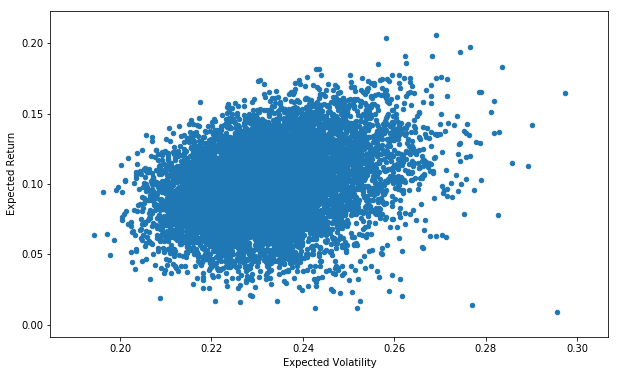

In [34]:
# Efficient Frontier 
pflio_scenarios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10,6));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

In [43]:
# For Testing purposes
index = 301
#index = len(pflio_scenarios)-1
pfolio_wei2 = []
tickers2 = []
tickers2 = np.array(tickers)
print(index)
print(np.sum(pflio_wei[index]))
pflio_wei2 = pflio_wei[index]



ideal_portfolio = pd.DataFrame({'Original Weights':my_portfolio['Weights'], 'Ideal Weights': pflio_wei2})
ideal_portfolio = pd.concat([symbols_df, ideal_portfolio], axis=1)
ideal_portfolio = ideal_portfolio.sort_values('Ideal Weights', ascending=False)
ideal_portfolio.to_csv('ideal_weights.csv', index=False)
ideal_portfolio

301
1.0000000000000002


,Symbol,Original Weights,Ideal Weights
0,AAPL,0.29,0.323642
4,TSLA,0.11,0.272879
1,BABA,0.16,0.137861
7,LUV,0.03,0.078280
6,JD,0.04,0.076094
8,DAL,0.03,0.055127
2,SPHD,0.14,0.019765
5,XOM,0.06,0.019319
3,BRK.B,0.14,0.017034


## Data Visualization

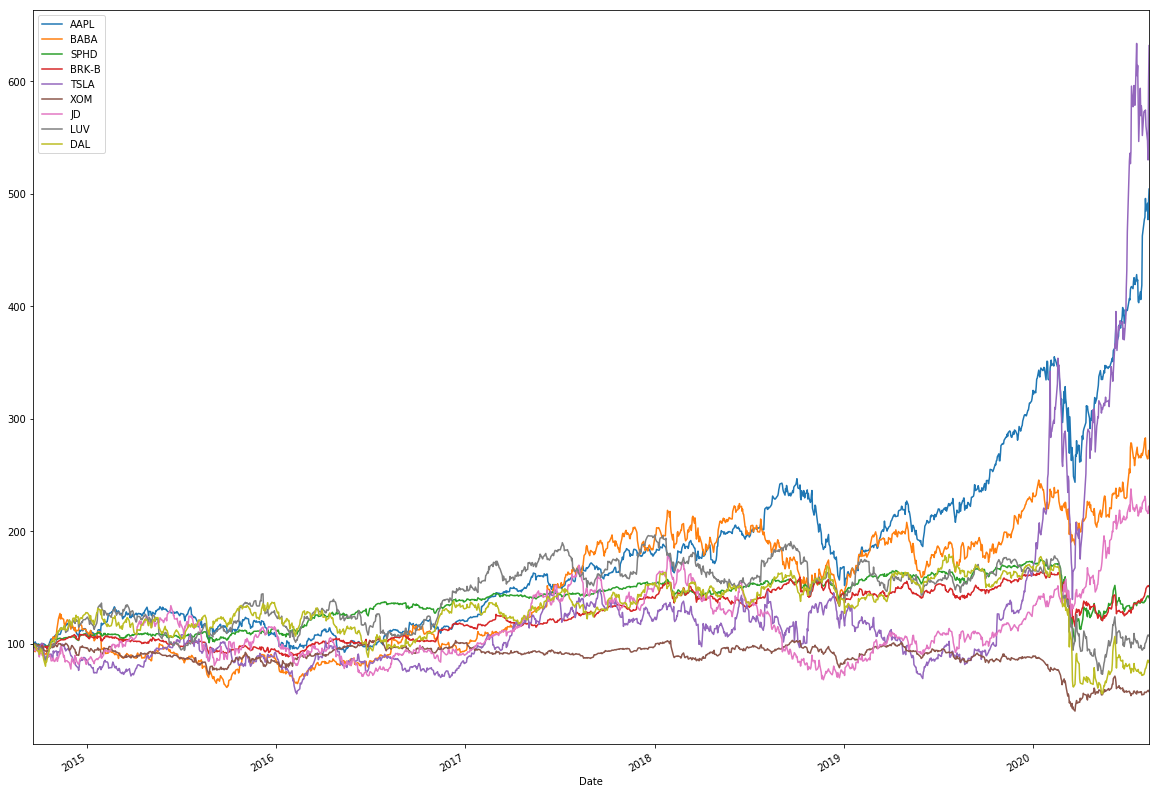

In [36]:
(historical_data/historical_data.iloc[0]*100).plot(figsize=(20,15))

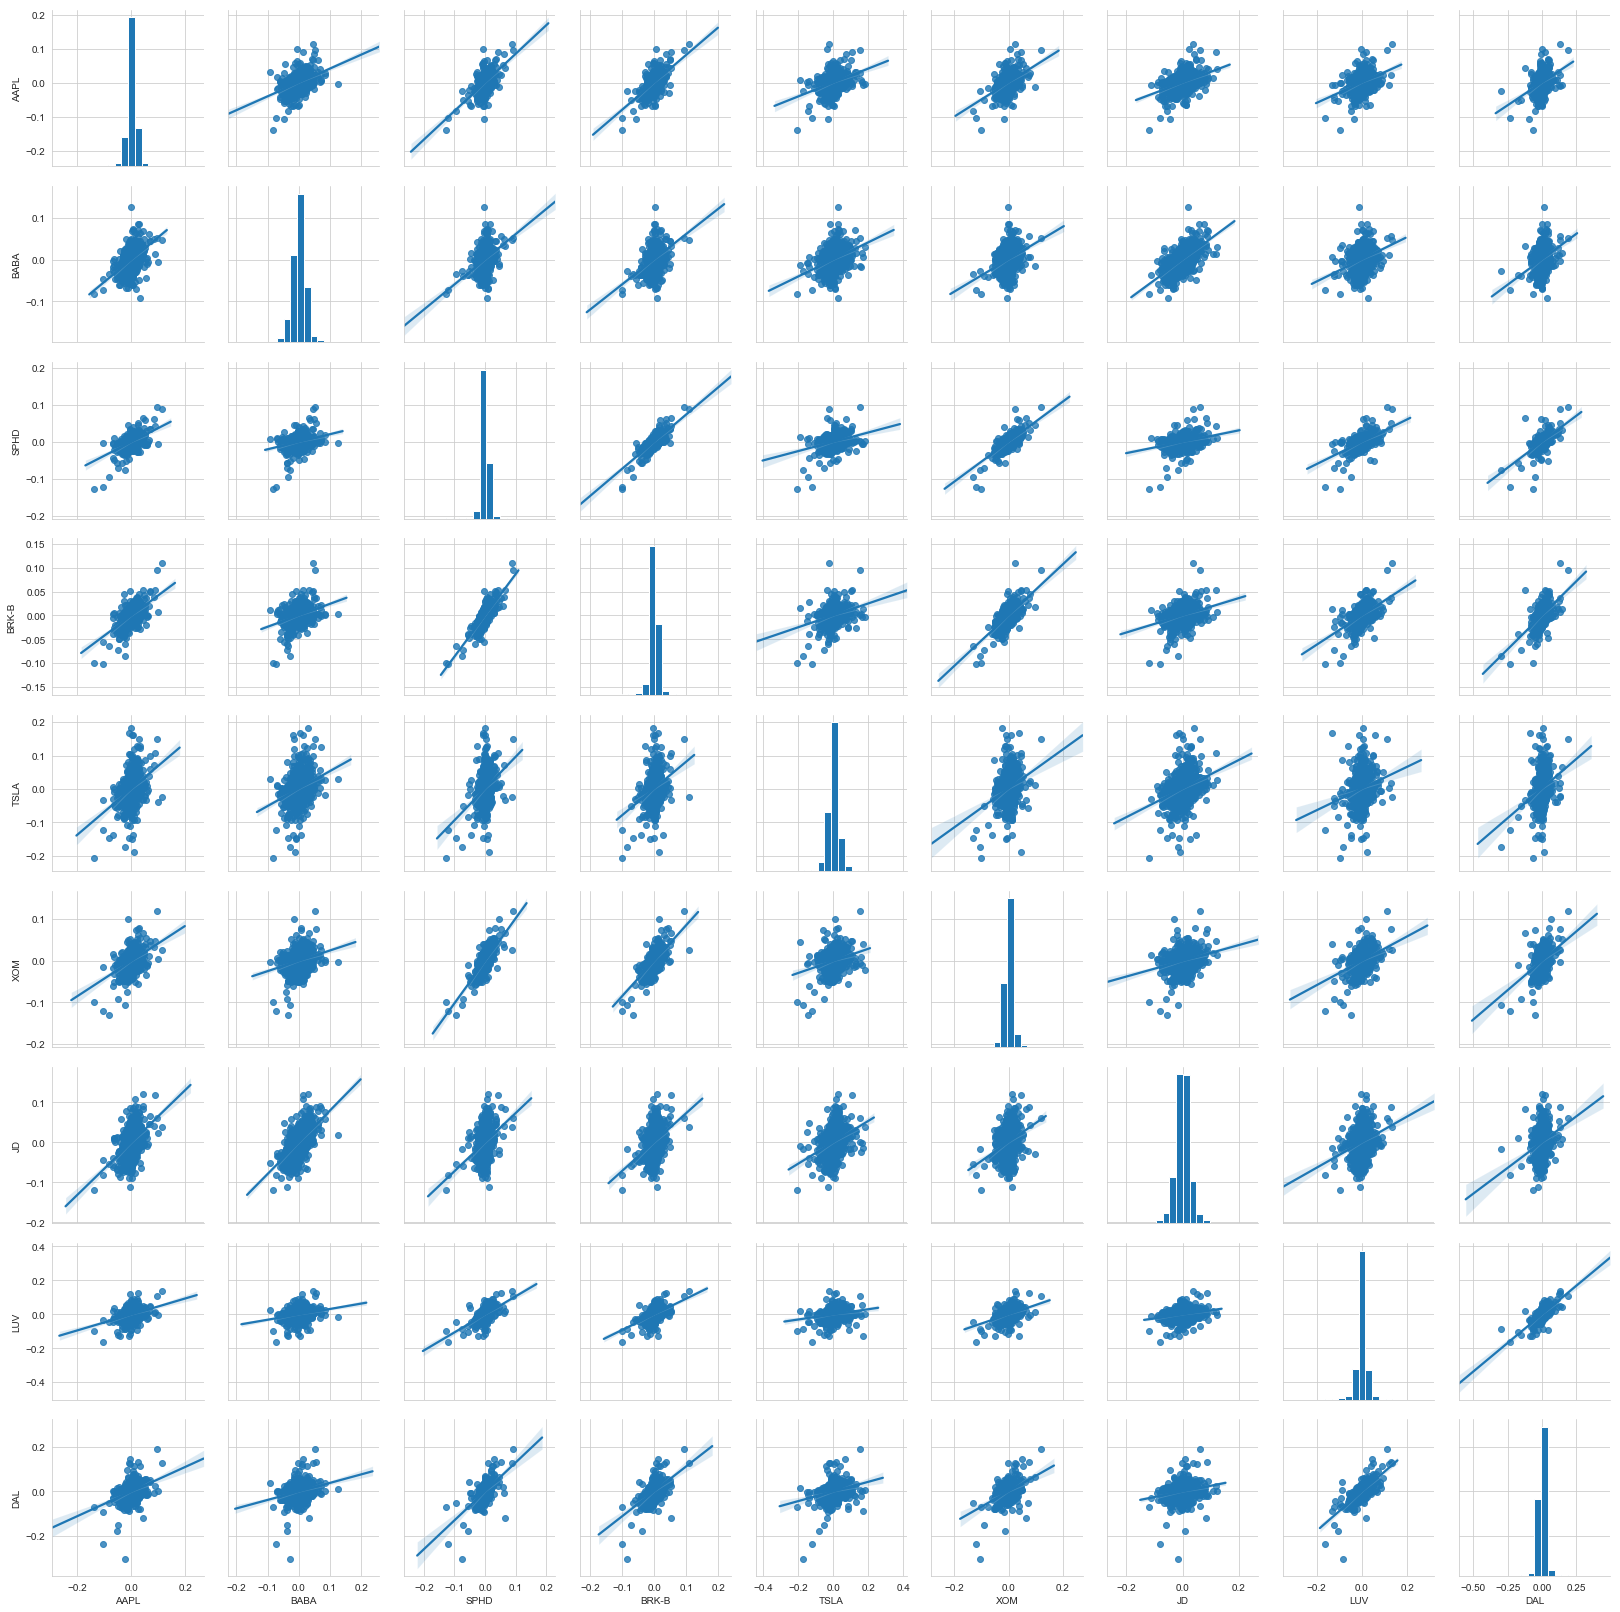

In [37]:
sns.set_style('whitegrid')
regression = sns.pairplot(returns[1:], kind="reg")
regression

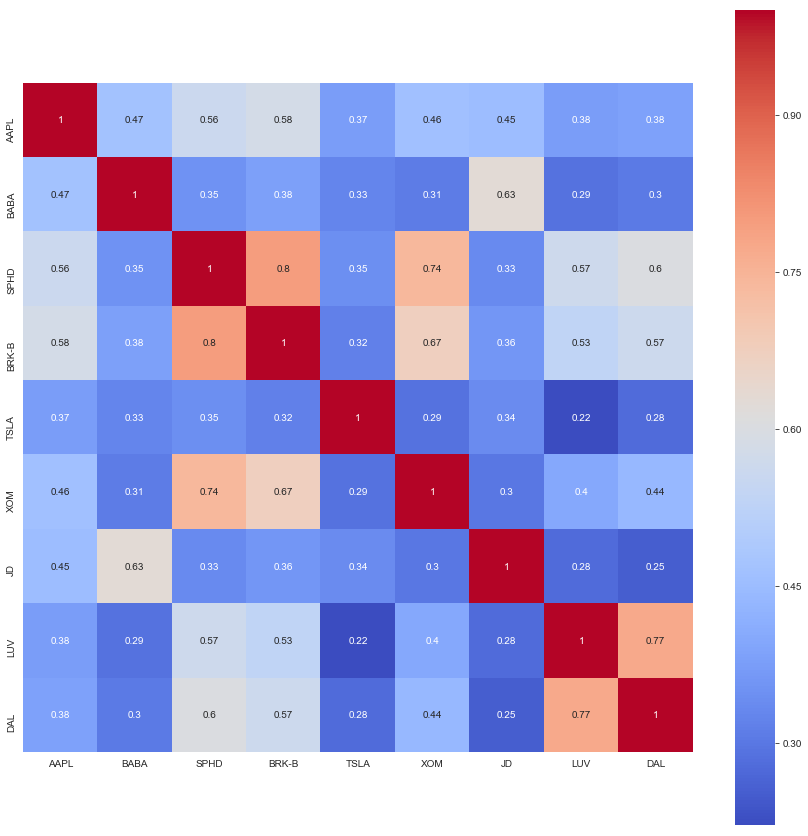

In [38]:
plt.subplots(figsize=(15, 15))
heatmap = sns.heatmap(return_corr, annot=True, square=True, cmap='coolwarm')
heatmap
